In [1]:
import pandas as pd
import nltk
import string
import seaborn as sns

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
yelp = pd.read_csv("new_yelp_eda_2000.csv")
yelp

,Rating,Label,Review_Text
0,5,-1,i love sakagura. ??its a bit hard to find but ...
1,4,1,"Ceviche mixto was great, the fish tacos were g..."
2,5,-1,Brooklyn's best-kept secret. Brunch and dinner...
3,2,1,Prepare to be annoyed. ??The food is unremarka...
4,4,-1,"Solid food, cute restaurant"
...,...,...,...
1995,5,-1,cheap and good thai food. you can try anything...
1996,2,-1,Good place w good environment but the fish was...
1997,3,1,Great Jones Cafe was a fun way to spend a Sund...
1998,5,-1,A diamond in the ruff. Food was fantastic and ...


In [4]:
# generate a graph to show the proportion of word count in sentence

yelp['length'] = yelp['Review_Text'].apply(len)
yelp

,Rating,Label,Review_Text,length
0,5,-1,i love sakagura. ??its a bit hard to find but ...,391
1,4,1,"Ceviche mixto was great, the fish tacos were g...",268
2,5,-1,Brooklyn's best-kept secret. Brunch and dinner...,133
3,2,1,Prepare to be annoyed. ??The food is unremarka...,106
4,4,-1,"Solid food, cute restaurant",27
...,...,...,...,...
1995,5,-1,cheap and good thai food. you can try anything...,125
1996,2,-1,Good place w good environment but the fish was...,361
1997,3,1,Great Jones Cafe was a fun way to spend a Sund...,725
1998,5,-1,A diamond in the ruff. Food was fantastic and ...,86


### Text Pre-processing

In [5]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

#text processing: to remove stop words and punctuations, and undergo tokenization
def text_processing(text):
    #stemming
    pst = PorterStemmer()
    
    #lemmalization
    word_lem = WordNetLemmatizer()
    
    #remove punctuations
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    #remove stopwords, stem and lemmatize the words
    tokens = []
    for word in text.split(' '):
#         word = word.lower()and word not in tokens:
        if word not in stopwords.words("english"):
            word = word_lem.lemmatize(word)
            word = pst.stem(word)
            tokens.append(word)
            
    #stemming
            
    return tokens

In [6]:
yelp['Review_Text'].apply(text_processing)

0       [love, sakagura, bit, hard, find, think, make,...
1       [cevich, mixto, great, fish, taco, great, tuna...
2       [brooklyn, bestkept, secret, brunch, dinner, s...
3       [prepar, annoy, the, food, unremark, the, deco...
4                            [solid, food, cute, restaur]
                              ...                        
1995    [cheap, good, thai, food, tri, anyth, everyth,...
1996    [good, place, w, good, environ, fish, bad, cou...
1997    [great, jone, cafe, fun, way, spend, sunday, a...
1998    [a, diamond, ruff, food, fantast, top, priorit...
1999    [i, last, night, anniversari, dinner, sinc, mo...
Name: Review_Text, Length: 2000, dtype: object

### Feature Engineering

In [7]:
#to create the instance of CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
transformer = CountVectorizer(analyzer=text_processing).fit(yelp['Review_Text'])

In [8]:
#transform the all sms messages to bag of words
text_message = transformer.transform(yelp['Review_Text'])

In [9]:
#compute the tfidf for all sms messages
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(text_message)

#store tfidf in the variable text_tfidf
text_tfidf = tfidf_transformer.transform(text_message)

### Training

In [10]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB().fit(text_tfidf , yelp['Label'])
nb.predict(text_tfidf)

predictions = nb.predict(text_tfidf)
print(predictions)

from sklearn.metrics import classification_report
print(classification_report(yelp['Label'], predictions))

[-1  1 -1 ...  1 -1 -1]
              precision    recall  f1-score   support

          -1       0.93      0.80      0.86      1000
           1       0.83      0.94      0.88      1000

    accuracy                           0.87      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.88      0.87      0.87      2000



In [11]:
#split to training set and testing set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(yelp['Review_Text'], yelp['Label'], test_size=0.3, random_state=42)                                     

In [12]:
#use sklearn.pipeline to conduct the prediction again on training data
from sklearn.pipeline import Pipeline
import time

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

In [14]:
#Naive Bayse with CV
start_time = time.time()

pipelineNB = Pipeline([
    ('bow', CountVectorizer(analyzer=text_processing)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())  
])

parameters = {
    'classifier__alpha': [0.1, 1, 10]
}

gs_testNB = GridSearchCV(estimator=pipelineNB, param_grid=parameters, error_score='raise')
gs_resultNB = gs_testNB.fit(x_train, y_train)
predictionNB = gs_resultNB.predict(x_test)
print(classification_report(predictionNB, y_test))

end_time = time.time()

# Calculate the duration in seconds
duration = end_time - start_time

# Print the duration
print("Modeling time: {:.2f} seconds".format(duration))

              precision    recall  f1-score   support

          -1       0.53      0.65      0.58       252
           1       0.70      0.59      0.64       348

    accuracy                           0.61       600
   macro avg       0.61      0.62      0.61       600
weighted avg       0.63      0.61      0.61       600

Modeling time: 369.29 seconds


In [15]:
#MLP with CV
start_time = time.time()

pipelineMLP = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MLPClassifier(random_state=1, max_iter=500))  
])

#parameters for cross validation
parameters = {
    'classifier__hidden_layer_sizes': [(100,), (100, 50), (50, 50)],
    'classifier__activation': ['relu', 'tanh'],
}

gs_testMLP = GridSearchCV(estimator=pipelineMLP, param_grid=parameters, error_score='raise')
gs_resultMLP = gs_testMLP.fit(x_train, y_train)
predictionMLP = gs_resultMLP.predict(x_test)
print(classification_report(predictionMLP, y_test))

end_time = time.time()

# Calculate the duration in seconds
duration = end_time - start_time

# Print the duration
print("Modeling time: {:.2f} seconds".format(duration))

              precision    recall  f1-score   support

          -1       0.54      0.60      0.57       275
           1       0.63      0.57      0.60       325

    accuracy                           0.58       600
   macro avg       0.58      0.58      0.58       600
weighted avg       0.59      0.58      0.58       600

Modeling time: 620.67 seconds


In [16]:
#Ensemble Method
#Naive Bayse & MLP with CV


from sklearn.ensemble import VotingClassifier

start_time = time.time()

pipelineNB = Pipeline([
    ('bow', CountVectorizer(analyzer=text_processing)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())  
])

pipelineMLP = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MLPClassifier(random_state=1, max_iter=500))  
])

ensembleNB_MLP = VotingClassifier(estimators=[('nb', pipelineNB), ('mlp', pipelineMLP)], voting='hard')

pipelineNB_MLP = Pipeline([
    ('ensemble', ensembleNB_MLP)
])

#parameters for cross validation
parameters = {
    'ensemble__weights': [(1, 1), (2, 1), (1, 2)],
}

gs_testNB_MLP = GridSearchCV(estimator=pipelineNB_MLP, param_grid=parameters, error_score='raise')
gs_resultNB_MLP = gs_testNB_MLP.fit(x_train, y_train)
predictionNB_MLP = gs_resultNB_MLP.predict(x_test)
print(classification_report(predictionNB_MLP, y_test))

end_time = time.time()

# Calculate the duration in seconds
duration = end_time - start_time

# Print the duration
print("Modeling time: {:.2f} seconds".format(duration))

              precision    recall  f1-score   support

          -1       0.36      0.68      0.47       164
           1       0.82      0.55      0.66       436

    accuracy                           0.58       600
   macro avg       0.59      0.61      0.56       600
weighted avg       0.69      0.58      0.61       600

Modeling time: 813.57 seconds


In [17]:
#Naive Bayse
start_time = time.time()

pipelineNB = Pipeline([
    ('bow', CountVectorizer(analyzer=text_processing)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())  
])
pipelineNB.fit(x_train, y_train)
predictionsNB = pipelineNB.predict(x_test)
print(classification_report(predictionsNB, y_test))

end_time = time.time()

# Calculate the duration in seconds
duration = end_time - start_time

# Print the duration
print("Modeling time: {:.2f} seconds".format(duration))

              precision    recall  f1-score   support

          -1       0.36      0.68      0.47       164
           1       0.82      0.55      0.66       436

    accuracy                           0.58       600
   macro avg       0.59      0.61      0.56       600
weighted avg       0.69      0.58      0.61       600

Modeling time: 73.90 seconds


In [18]:
#MLP
start_time = time.time()

from sklearn.neural_network import MLPClassifier

pipelineMLP = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MLPClassifier(random_state=1, max_iter=500))  
])

pipelineMLP.fit(x_train, y_train)
predictionsMLP = pipelineMLP.predict(x_test)
print(classification_report(predictionsMLP, y_test))

end_time = time.time()

# Calculate the duration in seconds
duration = end_time - start_time

# Print the duration
print("Modeling time: {:.2f} seconds".format(duration))

              precision    recall  f1-score   support

          -1       0.56      0.62      0.59       279
           1       0.63      0.58      0.61       321

    accuracy                           0.60       600
   macro avg       0.60      0.60      0.60       600
weighted avg       0.60      0.60      0.60       600

Modeling time: 44.90 seconds


In [19]:
#Ensemble Method
#Naive Bayse & MLP
start_time = time.time()

from sklearn.ensemble import VotingClassifier

pipelineNB = Pipeline([
    ('bow', CountVectorizer(analyzer=text_processing)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())  
])

pipelineMLP = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MLPClassifier(random_state=1, max_iter=500))  
])

ensembleNB_MLP = VotingClassifier(estimators=[('nb', pipelineNB), ('mlp', pipelineMLP)], voting='hard')

pipelineNB_MLP = Pipeline([
    ('ensemble', ensembleNB_MLP)
])

pipelineNB_MLP.fit(x_train, y_train)
predictionsNB_MLP = pipelineNB_MLP.predict(x_test)
print(classification_report(predictionsNB_MLP, y_test))

end_time = time.time()

# Calculate the duration in seconds
duration = end_time - start_time

# Print the duration
print("Modeling time: {:.2f} seconds".format(duration))

              precision    recall  f1-score   support

          -1       0.61      0.62      0.62       302
           1       0.61      0.60      0.61       298

    accuracy                           0.61       600
   macro avg       0.61      0.61      0.61       600
weighted avg       0.61      0.61      0.61       600

Modeling time: 115.42 seconds


In [23]:
print(yelp['Label'])

0      -1
1       1
2      -1
3       1
4      -1
       ..
1995   -1
1996   -1
1997    1
1998   -1
1999   -1
Name: Label, Length: 2000, dtype: int64


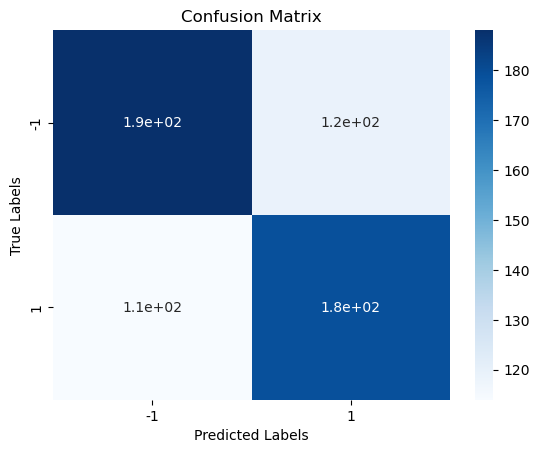

Predicted,-1,1
True,,
-1,188,119
1,114,179


In [38]:
import matplotlib.pyplot as plt
confusion = pd.DataFrame({'TrueLabels':y_test, 'PredictedLabels':predictionsNB_MLP})

# Compute the confusion matrix using crosstab
confusion_matrix = pd.crosstab(confusion['TrueLabels'], confusion['PredictedLabels'], rownames=['True'], colnames=['Predicted'])

# Create a heatmap using seaborn
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

confusion_matrix